# Figure 7: Average rank obtained per augmentation and dataset.

[:simple-jupyter: :material-download:](../../paper_tables_and_figures/figure7_augmentations_comparison_across_datasets_average_rank/figure7_augmentations_comparison_across_datasets_average_rank.ipynb)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import autorank
import pandas as pd

In [3]:
dat = {
    "mirage19": pd.read_parquet(
        "./campaigns/mirage19/augmentation-at-loading-no-dropout/minpkts10/campaign_summary/augment-at-loading/runsinfo_flowpic_dim_32.parquet"
    ),
    "mirage22_10": pd.read_parquet(
        "./campaigns/mirage22/augmentation-at-loading-no-dropout/minpkts10/campaign_summary/augment-at-loading/runsinfo_flowpic_dim_32.parquet"
    ),
    "mirage22_1000": pd.read_parquet(
        "./campaigns/mirage22/augmentation-at-loading-no-dropout/minpkts1000/campaign_summary/augment-at-loading/runsinfo_flowpic_dim_32.parquet"
    ),
    "utmobile19": pd.read_parquet(
        "./campaigns/utmobilenet21/augmentation-at-loading-no-dropout/minpkts10/campaign_summary/augment-at-loading/runsinfo_flowpic_dim_32.parquet"
    ),
}

In [4]:
def prepare_data(df):
    res = df[["hash", "aug_name", "seed", "split_index", "f1"]]
    res.loc[:, "id"] = (
        "split_index"
        + res.loc[:, "split_index"].astype(str)
        + "_seed"
        + res.loc[:, "seed"].astype(str)
    )
    res = res[["aug_name", "id", "f1"]]
    return res.sort_values(["aug_name", "id"])


def get_ranks(df):
    df1 = prepare_data(df)
    df1 = df1.pivot(columns="aug_name", index="id").reset_index(drop=True)
    df1.columns = df1.columns.get_level_values(1)
    new_df = pd.DataFrame(
        {
            "changertt": df1["changertt"].values,
            "colorjitter": df1["colorjitter"].values,
            "horizontalflip": df1["horizontalflip"].values,
            "noaug": df1["noaug"].values,
            "packetloss": df1["packetloss"].values,
            "rotate": df1["rotate"].values,
            "timeshift": df1["timeshift"].values,
        }
    )
    replacement = {
        "noaug": "No augmentation",
        "horizontalflip": "Horizontal flip",
        "rotate": "Rotate",
        "timeshift": "Time shift",
        "colorjitter": "Color jitter",
        "changertt": "Change RTT",
        "packetloss": "Packet Loss",
    }
    new_df = new_df.rename(columns=replacement).dropna()
    rankmat = new_df.rank(axis="columns", ascending=False)
    return rankmat

In [5]:
def prepare_ranks_data(dataset):
    res = get_ranks(dat[dataset])
    res["dataset"] = dataset
    return res


together = pd.concat(
    [
        prepare_ranks_data("mirage19"),
        prepare_ranks_data("mirage22_10"),
        prepare_ranks_data("mirage22_1000"),
        prepare_ranks_data("utmobile19"),
    ]
)

df_tmp = pd.melt(
    together, id_vars=["dataset"], var_name="augmentation", value_name="rank"
)

/tmp/ipykernel_13347/159222887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:, "id"] = (
/tmp/ipykernel_13347/159222887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.loc[:, "id"] = (
/tmp/ipykernel_13347/159222887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [8]:
df_tmp2

dataset,mirage19,mirage22_10,mirage22_1000,utmobile19
augmentation,,,,
Change RTT,1.000000,1.733333,1.666667,3.466667
Color jitter,5.600000,5.533333,5.800000,3.800000
Horizontal flip,3.333333,3.266667,5.200000,5.266667
No augmentation,3.000000,4.533333,4.933333,4.933333
Packet Loss,5.333333,3.533333,3.333333,5.933333
Rotate,7.000000,6.733333,3.400000,2.466667
Time shift,2.733333,2.666667,3.666667,2.133333


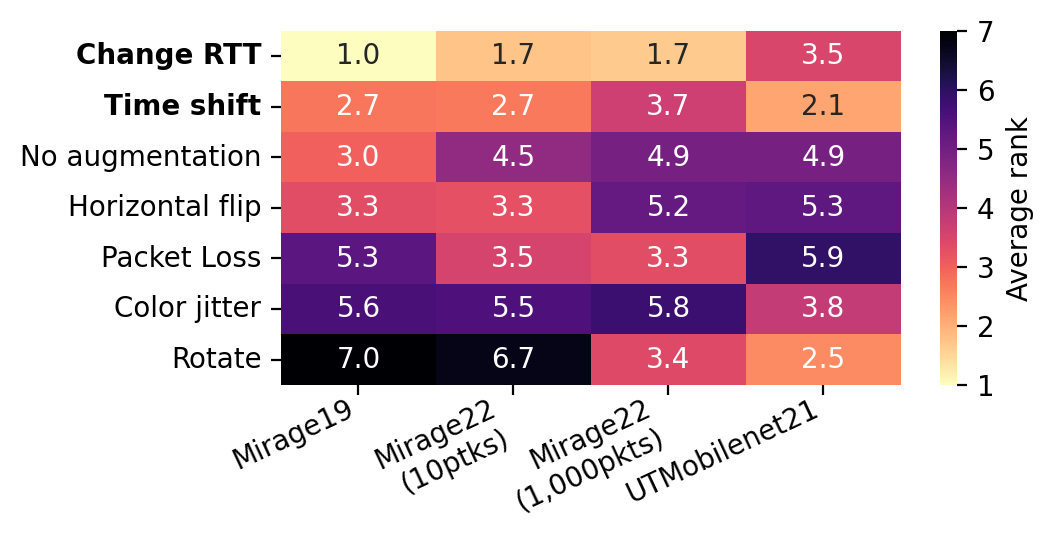

In [27]:
df_tmp2 = df_tmp.groupby(["dataset", "augmentation"])["rank"].mean().reset_index()
df_tmp2 = df_tmp2.pivot(index="augmentation", columns="dataset", values="rank")
df_tmp2 = df_tmp2.rename(
    {
        "mirage19": "Mirage19",
        "mirage22_10": "Mirage22\n(10ptks)",
        "mirage22_1000": "Mirage22\n(1,000pkts)",
        "utmobile19": "UTMobilenet21",
    },
    axis=1,
)
df_tmp2 = df_tmp2.sort_values(by="Mirage19", ascending=True)

fig, ax = plt.subplots(figsize=(5, 2.3))
ax = sns.heatmap(
    ax=ax,
    data=df_tmp2,
    annot=True,
    fmt=".1f",
    cmap=plt.get_cmap("magma_r"),
    cbar_kws=dict(label="Average rank"),
)

for lab in ax.get_yticklabels():
    if lab.get_text() in ("Change RTT", "Time shift"):
        lab.set_fontweight("bold")

ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
ax.tick_params(axis="x", which="major", pad=0)
ax.set_ylabel(None)
ax.set_xlabel(None)

plt.savefig("augmentations_rank_comparison_together2.png", bbox_inches="tight", dpi=300)